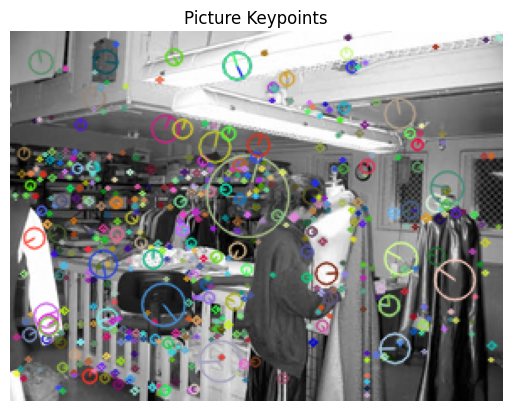

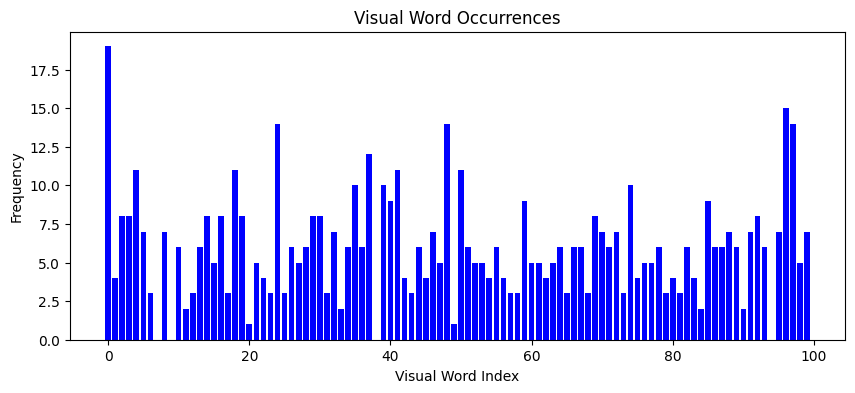

              precision    recall  f1-score   support

          00       0.33      0.27      0.30        70
          01       0.79      0.94      0.86        64
          02       0.40      0.35      0.37        95
          03       0.31      0.22      0.26        69
          04       0.41      0.43      0.42        95
          05       0.56      0.78      0.65       101
          06       0.76      0.90      0.83        93
          07       0.59      0.61      0.60        72
          08       0.56      0.53      0.54        83
          09       0.71      0.67      0.69       112
          10       0.62      0.55      0.59       118
          11       0.57      0.53      0.55       101
          12       0.67      0.57      0.62       109
          13       0.38      0.58      0.46        57
          14       0.68      0.61      0.64       107

    accuracy                           0.57      1346
   macro avg       0.56      0.57      0.56      1346
weighted avg       0.57   

In [18]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt


#  加载数据
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        path = os.path.join(folder, label)
        if os.path.isdir(path):
            for image_filename in os.listdir(path):
                img = cv2.imread(
                    os.path.join(path, image_filename), cv2.IMREAD_GRAYSCALE
                )
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels


folder = "data/15-Scene"
test_folder = "data/test_img"  # 仅仅用测试
images, labels = load_images_from_folder(folder)
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.3, random_state=42
)


# sift提取特征
def extract_sift_features(X):
    sift = cv2.SIFT_create()
    keypoints = []
    descriptors = []
    for img in X:
        kp, des = sift.detectAndCompute(img, None)
        keypoints.append(kp)
        descriptors.append(des)
        # print(des.shape) # 看看维度，默认特征序列长度为128
    return descriptors, keypoints


def show_features_in_img(X, keypoints):
    # 绘制关键点
    img_with_keypoints = cv2.drawKeypoints(
        X, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # 使用matplotlib显示图
    plt.imshow(img_with_keypoints)
    plt.title("Picture Keypoints")
    plt.axis("off")
    plt.show()


train_descriptors, train_keypoints = extract_sift_features(X_train)
test_descriptors, test_keypoints = extract_sift_features(X_test)


show_features_in_img(X_train[0], train_keypoints[0])


def build_vocabulary(descriptors_list, k):
    all_descriptors = np.vstack(descriptors_list)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans


k = 100  # 根据需要调整K值
vocab_model = build_vocabulary(train_descriptors, k)


def features_to_histogram(features, vocab_model):
    histogram = np.zeros(len(vocab_model.cluster_centers_))
    words = vocab_model.predict(features)
    for w in words:
        histogram[w] += 1
    return histogram


def prepare_histograms(descriptors_list, vocab_model):
    histograms = []
    for descriptors in descriptors_list:
        if descriptors is not None:
            histogram = features_to_histogram(descriptors, vocab_model)
            histograms.append(histogram)
        else:
            histograms.append(None)
    return histograms


def plot_histogram(histogram):
    # 创建一个条形图
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(histogram)), histogram, color="blue")  # 为每个视觉词生成一个条形
    plt.title("Visual Word Occurrences")
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.show()


train_histograms = prepare_histograms(train_descriptors, vocab_model)
test_histograms = prepare_histograms(test_descriptors, vocab_model)

plot_histogram(train_histograms[0])

# 处理可能的None值
train_histograms = [
    hist if hist is not None else np.zeros(k) for hist in train_histograms
]
test_histograms = [
    hist if hist is not None else np.zeros(k) for hist in test_histograms
]

# SVM训练
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

kernel = 'rbf'
clf = SVC(kernel=kernel) 
clf.fit(train_histograms, y_train_encoded)


predictions = clf.predict(test_histograms)
print(classification_report(y_test_encoded, predictions, target_names=le.classes_))

In [19]:
kernel = "linear"
clf = SVC(kernel=kernel)
clf.fit(train_histograms, y_train_encoded)


predictions = clf.predict(test_histograms)
print(classification_report(y_test_encoded, predictions, target_names=le.classes_))

              precision    recall  f1-score   support

          00       0.17      0.21      0.19        70
          01       0.78      0.97      0.87        64
          02       0.24      0.34      0.28        95
          03       0.25      0.26      0.25        69
          04       0.40      0.35      0.37        95
          05       0.54      0.67      0.60       101
          06       0.83      0.81      0.82        93
          07       0.53      0.56      0.54        72
          08       0.38      0.36      0.37        83
          09       0.65      0.57      0.61       112
          10       0.53      0.52      0.52       118
          11       0.52      0.37      0.43       101
          12       0.61      0.54      0.58       109
          13       0.42      0.44      0.43        57
          14       0.59      0.44      0.50       107

    accuracy                           0.49      1346
   macro avg       0.50      0.49      0.49      1346
weighted avg       0.51   